In [172]:
# Download data file locally 

import os
import urllib.request


# downloads the ds_salaries.csv file

def fetch_data():
    csv_path = "insurance.csv";
    return urllib.request.urlretrieve(csv_path)
    
fetch_data()

In [173]:
# Read the data file

import pandas as pd

def read_data():
    data = pd.read_csv("insurance.csv")
    return data;

In [174]:
data = read_data()
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [176]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<Axes: >

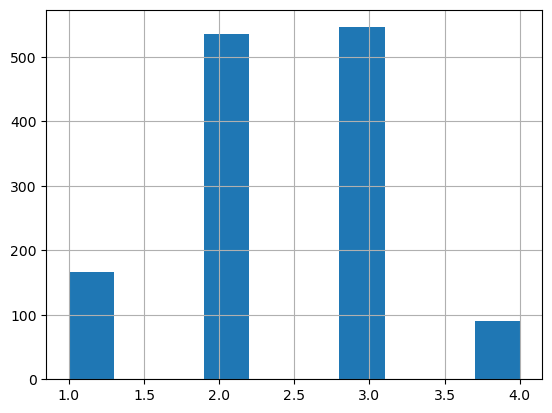

In [177]:
# Categories by the number of bedrooms
import numpy as np
# This is called stratified sampling: the population is divided
# into homogeneous subgroups called strata, and the right number of instances are
# sampled from each stratum to guarantee that the test set is representative of the
# overall population.

# you should not have too many strata, and each stratum should be large enough

data['age_cat'] = pd.cut(data['age'],
                              bins=[0., 20., 40., 60., 80],
                              labels=[1, 2, 3, 4])

data['age_cat'].hist()

In [178]:
# Statistically-based sampling

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['age_cat']):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
strat_test_set['age_cat'].value_counts()/len(strat_test_set)

age_cat
3    0.410448
2    0.399254
1    0.123134
4    0.067164
Name: count, dtype: float64

In [179]:
# Drop 'age_cat' column from the dataset to come back to the original set of columns

for set_ in (strat_train_set, strat_test_set):
    set_.drop("age_cat", axis=1, inplace=True)

In [180]:
len(strat_train_set)

1070

In [181]:
len(strat_test_set)

268

In [182]:
# Copy Train set
data_train = strat_train_set.copy()

In [183]:
# Calculate correlation
numeric_columns = data_train.select_dtypes(include=[np.number])
corr_matrix = numeric_columns.corr()
corr_matrix['charges'].sort_values(ascending=False)

charges     1.000000
age         0.301354
bmi         0.221792
children    0.074553
Name: charges, dtype: float64

In [184]:
# Prepare the Data for Machine Learning Algorithms

# drop() creates a copy of the data and does not affect strat_train_set
X = strat_train_set.drop('charges', axis=1)
y = strat_train_set["charges"].copy()

In [185]:
# Transformation Pipelines

# Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

data_num = X.drop(['sex', 'smoker', 'region'], axis=1)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

data_num_tr = num_pipeline.fit_transform(data_num)

In [186]:
# ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attribs = list(data_num)
cat_attribs = ["sex", "smoker", "region"]
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
    ])

data_prepared = full_pipeline.fit_transform(X)

In [187]:
# Convert charges into categories based on price ranges
def categorize_charges(charge):
    if charge < 10000:
        return 'low'
    elif charge < 20000:
        return 'medium'
    else:
        return 'high'

# Apply categorization function to charges column
y_cat = y.copy()
y_cat = y_cat.apply(categorize_charges)

# Rest of the code remains the same...


In [188]:
# Split the dataset into training and testing sets

X_test = strat_test_set.drop('charges', axis=1)
y_test = strat_test_set["charges"].copy()

X_test_prepared = full_pipeline.transform(X_test)
y_test_prepared = y_test.apply(categorize_charges)

## DecisionTreeClassifier

In [189]:
# Instantiate the DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=3)

# Train the classifier
tree_clf.fit(data_prepared, y_cat)

DecisionTreeClassifier(max_depth=3)

In [190]:
# Predict on the testing set
y_pred = tree_clf.predict(X_test_prepared)

In [191]:
# Evaluate the classifier
accuracy = accuracy_score(y_test_prepared, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8768656716417911


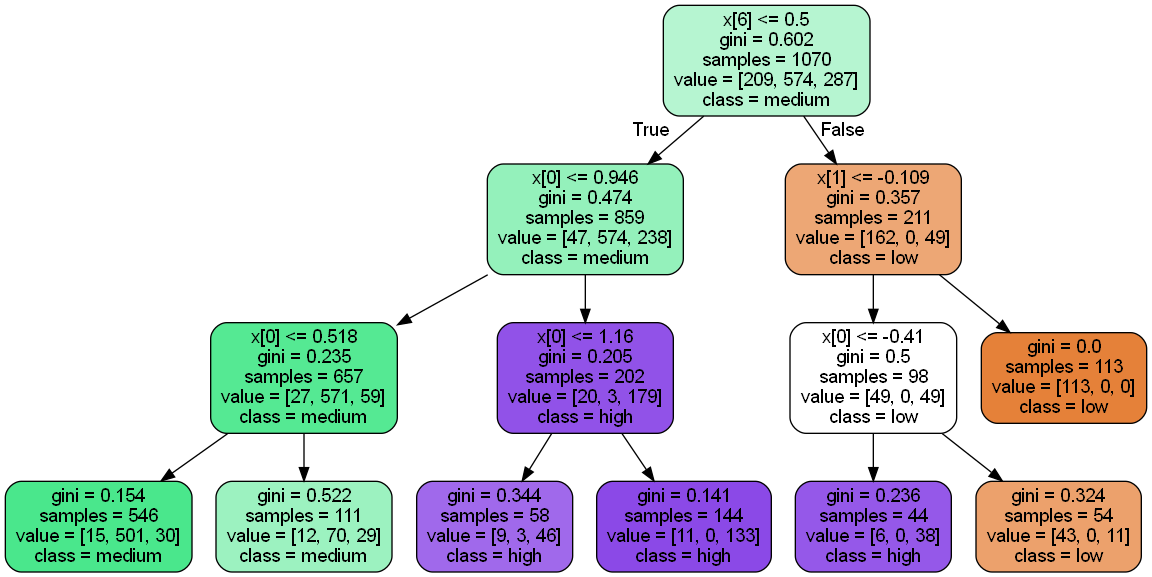

In [205]:
# Visualizing the Tree
import pydot
from IPython.display import Image
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="insurance_tree.dot",
    class_names=['low', 'medium', 'high'],
    rounded=True,
    filled=True
)

(graph,) = pydot.graph_from_dot_file("insurance_tree.dot")
graph.write_png("insurance_tree.png")

Image("insurance_tree.png")

## DecisionTreeRegressor

In [193]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(data_prepared, y)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [194]:
grid_search_cv.best_estimator_

DecisionTreeRegressor(max_leaf_nodes=10, random_state=42)

In [195]:
y_reg_pred = grid_search_cv.predict(X_test_prepared)

In [198]:
from sklearn.metrics import mean_squared_error

tree_mse = mean_squared_error(y_test, y_reg_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

4910.136744593249

In [206]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_reg_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_reg_pred)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_reg_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) score:", r2)

Mean Absolute Error (MAE): 2862.648342799782
Mean Squared Error (MSE): 24109442.850604795
R-squared (R2) score: 0.836294600693956


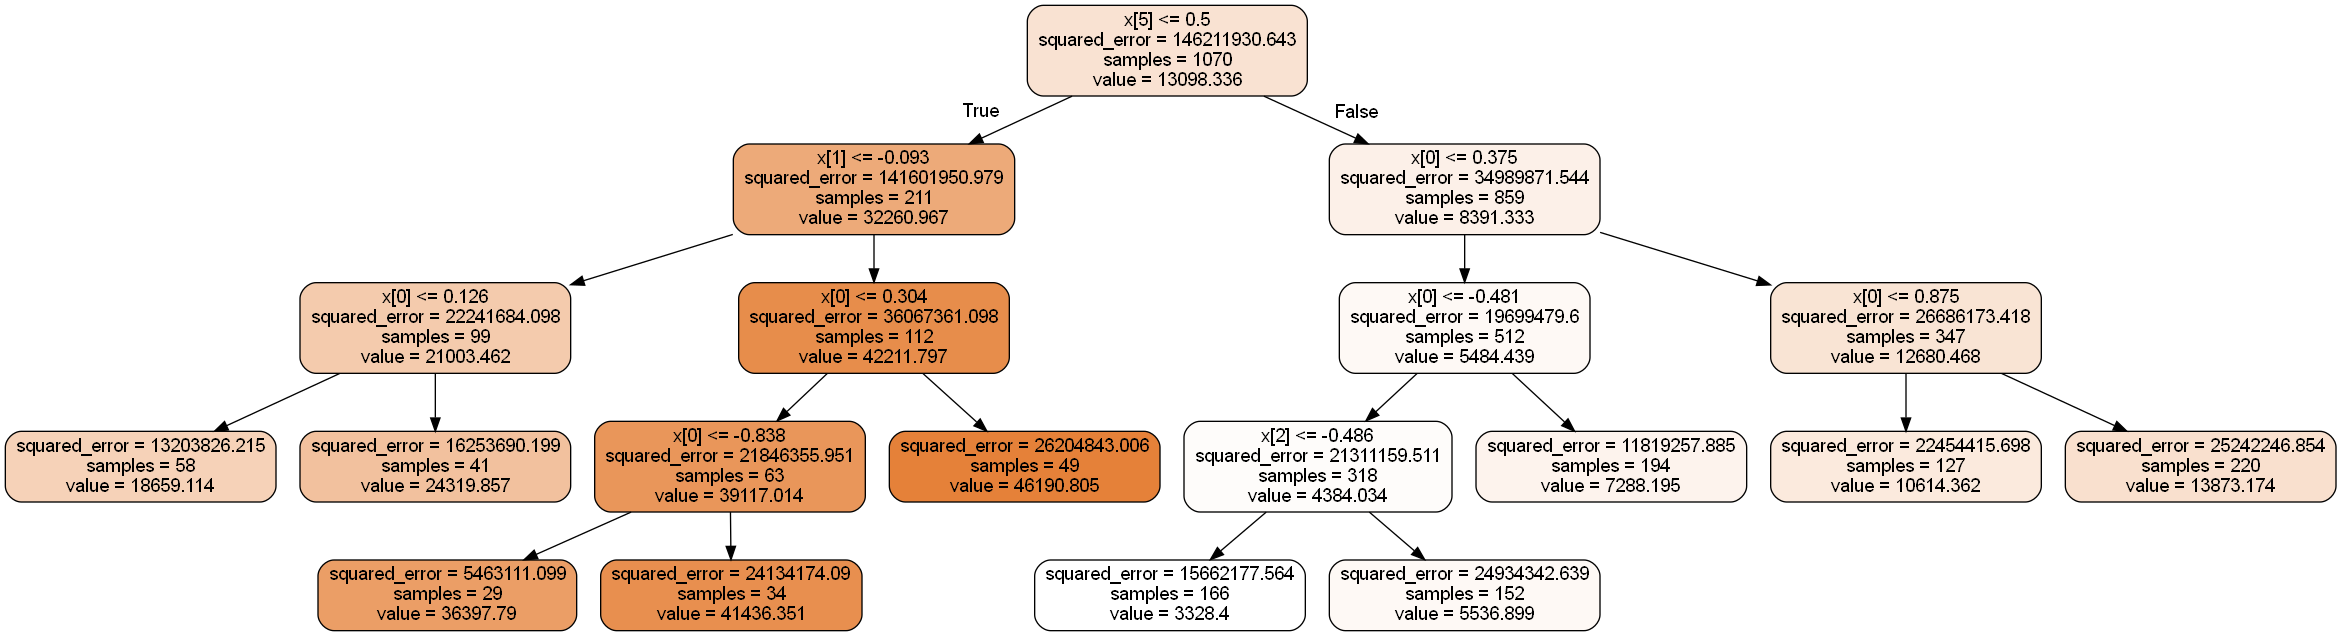

In [200]:
# Visualizing the Tree
import pydot
from IPython.display import Image
from sklearn.tree import export_graphviz

export_graphviz(
    grid_search_cv.best_estimator_,
    out_file="insurance_reg_tree.dot",
    rounded=True,
    filled=True
)

(graph,) = pydot.graph_from_dot_file("insurance_reg_tree.dot")
graph.write_png("insurance_reg_tree.png")

Image("insurance_reg_tree.png")